# Analyse backscattered data
Script is used for data in `Masterarbeit\Alsdorf\Daten\export_PCMario\export_txt\16042021_22042021`

Data has to follow naming convention, important for import:

channelname_datatype_whatyouwant.txt

channelname: chx: x has to be a one-digit number

datatype: a three digit string

However the skript could be relativly easy adapted

Data has also to follow a specific format. I should name the settings for the Charon3 export here!

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

def import_Stokes_and_AntiStokes(data_path):
    """import backscattered data
    input: data_path: Path to the file, which has been exported with Charon3
    A specific structure of the file is assumed! 
    E.g. Stokes first columns, empty column between Stokes and AntiStokes columns
    The number of columns (timespan of datafile) is variable

    returns two dataframes: Stokes and AntiStokes

    Improving:
    this can be improved by skipping columns, while loading: https://stackoverflow.com/questions/48899051/how-to-drop-a-specific-column-of-csv-file-while-reading-it-using-pandas
    not sure if it works with using columns names, because they are all the same.
    If they are re-labeled, before applying the suggested workflow it becomes more difficult.
    Did not test it yet.
    """
    def import_dataframe(data_path,skipr,low_m=True):
        """
        low_m=True is also default in pd.read_csv
        """
        df = pd.read_csv(data_path, delimiter="\t", skiprows=skipr, index_col=1,decimal=",",low_memory=low_m)
        df.drop([df.columns[0], df.columns[1]] , axis=1,inplace=True)
        return df

    #complete dataframe
    df=import_dataframe(data_path,skipr=3)


    # dataframe to read which columns are stokes and antistokes
    # in the other dataframe this information is lost due to skipping the first 3 rows
    # but by skipping only two rows the data types are recogniced bad,
    # therfore this Stokes and AntiStokes columns names are read in seperate in the following
    # column types is used to divide the dataframe into stokes and antistokes
    column_types=import_dataframe(data_path,skipr=2,low_m=False)

    n_antiStokes=len(column_types.filter(regex="Anti").columns) #number of anti-stokes columns
    n_total=len(column_types.columns)-1 #-1 for emtpy column between stokes and anti stokes
    n_Stokes=n_total-n_antiStokes
    # a basic check if the data format is as expected
    if n_Stokes != n_antiStokes:
        print("the data has not the expected format")
    index_last_Stokes_column=n_Stokes-1 # due to python starting count at 0


    # Seperate stokes and antistokes data
    # +1 for empty column between stokes and anty stokes; +1 because upper border is excluded
    AntiStokes=df.drop(df.columns[:index_last_Stokes_column+1+1],axis=1)
    # +1 because last stoke column has to be kept
    Stokes=df.drop(df.columns[index_last_Stokes_column+1:],axis=1)
    AntiStokes.index.names = ['Length [m]']
    Stokes.index.names = ['Length [m]']

    #rename Antistoeks columns
    #did not copy the stokes column names (they have the same date), 
    # because like this errors are better detectable
    # they have a .1 at the end (created by pd.read_csv) because they have the same name as the 
    # stokes columns, this has been added to avoid the same filenames
    new_column_names=[]
    for i in range(len(AntiStokes.columns)):
        new_column_names.append(AntiStokes.columns[i][:-2])
    AntiStokes.columns=new_column_names

    return Stokes, AntiStokes

def import_temp(path):
    """import temperature data"""
    df = pd.read_csv(path,delimiter = '\t',index_col=1, header=3, decimal=",")
    df = df.drop(df.columns[[0]], axis=1)
    df.index.names = ['Depth [m]']

    #If I want to transform the header this is a could starting point
    #df.index=pd.to_datetime(df.index, dayfirst = True).tz_localize(None)
    #df.index=df.index.astype(str) # same column format as other dataframe
    
    return df

def get_abspath(basepath):
    """Get the files you need to import into your script with Path
    Returns a list of all filepaths (or folderpaths) of the files (or folders) in a repository.
    The repository is given this function with basepath.
    """
    df_list = []
    basepath = glob.glob(basepath)
    for entry in basepath:
        df_list.append(entry)
    return (df_list)

In [2]:
# Import Data
folder_path=r"..\Alsdorf\Daten\export_PCMario\export_txt\16042021_22042021" # you can change this
list_data_paths=get_abspath(folder_path + "\*") #gets path of all files in folder_path

stokes_16to22_042021={} #conatins stokes dataframes
antistokes_16to22_042021={} #conatins anti-stokes dataframes
temp_16to22_042021={} #contains temp dataframes
for path in list_data_paths: #for every file do:
    filename=path.replace(folder_path,"")
    filename=filename[1:] #remove "\" at beginning
    channel=filename[0:3] #channelname: chx
    datatype=filename[4:8] #datatype: back or temp

    if datatype == "back": #backscattered data
        stokes_16to22_042021[channel], antistokes_16to22_042021[channel] = import_Stokes_and_AntiStokes(path)

    if datatype == "temp": #temperature data
        temp_16to22_042021[channel]=import_temp(path)

# Dsiplay imported data
print("Stokes data:")
display(stokes_16to22_042021["ch1"])
print("Anti-Stokes data")
display(antistokes_16to22_042021["ch1"])
print("Temperature data:")
display(temp_16to22_042021["ch1"])

Stokes data:


,16.04.2021 10:49:27,16.04.2021 11:05:28,16.04.2021 11:37:30,16.04.2021 11:53:30,16.04.2021 12:09:31,16.04.2021 12:25:32,16.04.2021 12:41:32,16.04.2021 12:57:33,16.04.2021 13:13:34,16.04.2021 13:29:34,...,21.04.2021 22:23:12,21.04.2021 22:39:13,21.04.2021 22:55:13,21.04.2021 23:11:14,21.04.2021 23:27:15,21.04.2021 23:43:15,21.04.2021 23:59:16,22.04.2021 00:15:17,22.04.2021 00:31:18,22.04.2021 00:47:18
Length [m],,,,,,,,,,,,,,,,,,,,,
-129.0,3242.97,3285.07,3280.31,3254.88,3241.09,3241.57,3253.43,3270.83,3300.02,3316.63,...,3281.92,3282.94,3282.44,3284.04,3282.96,3281.38,3281.51,3280.53,3278.92,3276.99
-128.0,4637.50,4678.55,4675.21,4649.93,4635.76,4638.24,4654.66,4674.22,4701.17,4715.03,...,4680.39,4682.62,4682.63,4683.01,4683.42,4682.16,4681.24,4679.39,4677.54,4675.63
-127.0,4428.88,4458.92,4459.50,4445.66,4431.44,4427.51,4432.27,4438.97,4455.53,4465.71,...,4448.57,4450.45,4450.87,4450.56,4451.07,4449.93,4448.34,4446.90,4445.97,4444.28
-126.0,4284.44,4309.85,4310.76,4301.63,4287.96,4279.28,4277.01,4277.67,4289.78,4298.63,...,4288.39,4289.62,4289.87,4290.49,4289.66,4289.02,4289.08,4288.18,4288.01,4287.66
-125.0,4233.40,4254.78,4252.99,4244.38,4234.90,4227.59,4224.31,4226.44,4237.95,4245.32,...,4235.05,4236.40,4237.85,4238.48,4236.96,4236.73,4237.70,4237.81,4237.94,4238.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816.0,-20.60,-18.10,-27.32,-23.59,-25.62,-24.78,-25.58,-29.31,-24.45,-23.12,...,-23.80,-21.50,-22.41,-22.41,-20.90,-21.06,-21.94,-20.70,-19.50,-22.13
1817.0,-19.62,-17.95,-26.25,-22.20,-23.99,-22.58,-24.18,-28.52,-23.64,-22.66,...,-21.09,-20.14,-21.97,-21.82,-20.64,-19.56,-19.90,-20.18,-19.05,-20.57
1818.0,-18.94,-17.43,-26.36,-21.98,-23.45,-22.12,-24.09,-29.38,-23.41,-21.69,...,-20.99,-20.56,-21.88,-20.86,-20.29,-19.08,-19.55,-20.48,-19.90,-20.92


Anti-Stokes data


,16.04.2021 10:49:27,16.04.2021 11:05:28,16.04.2021 11:37:30,16.04.2021 11:53:30,16.04.2021 12:09:31,16.04.2021 12:25:32,16.04.2021 12:41:32,16.04.2021 12:57:33,16.04.2021 13:13:34,16.04.2021 13:29:34,...,21.04.2021 22:23:12,21.04.2021 22:39:13,21.04.2021 22:55:13,21.04.2021 23:11:14,21.04.2021 23:27:15,21.04.2021 23:43:15,21.04.2021 23:59:16,22.04.2021 00:15:17,22.04.2021 00:31:18,22.04.2021 00:47:18
Length [m],,,,,,,,,,,,,,,,,,,,,
-129.0,10761.03,10802.69,10765.16,10719.40,10726.62,10813.39,10962.81,11090.13,11179.03,11222.59,...,11212.67,11215.11,11214.63,11213.14,11212.20,11210.65,11212.39,11213.44,11211.29,11207.01
-128.0,11067.34,11125.43,11107.88,11065.25,11059.54,11110.91,11209.13,11295.24,11375.43,11432.38,...,11451.08,11454.04,11455.15,11452.47,11450.56,11447.25,11446.57,11443.75,11439.21,11434.52
-127.0,7666.91,7716.34,7721.36,7702.07,7682.41,7672.19,7677.06,7685.75,7719.80,7758.55,...,7776.19,7779.27,7780.45,7778.37,7775.43,7772.34,7772.01,7766.82,7763.08,7759.83
-126.0,6814.84,6835.81,6833.85,6826.97,6813.92,6806.10,6809.63,6813.81,6823.63,6828.15,...,6808.18,6809.54,6809.95,6810.52,6808.03,6808.09,6812.26,6809.71,6809.02,6806.53
-125.0,6800.72,6798.26,6788.82,6789.42,6787.75,6798.13,6815.62,6827.82,6836.28,6828.37,...,6803.89,6804.44,6803.59,6804.43,6801.50,6802.65,6808.15,6809.61,6810.33,6806.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816.0,23.66,22.54,11.15,14.12,13.75,17.52,16.09,6.17,12.97,20.69,...,19.40,18.94,18.87,19.60,19.29,22.06,23.01,22.58,24.85,24.53
1817.0,25.06,25.36,12.27,16.48,15.74,18.05,15.33,7.11,15.98,21.10,...,20.90,18.94,19.31,21.13,19.36,21.98,24.56,23.34,24.79,25.59
1818.0,25.25,27.98,15.48,19.60,18.91,20.13,16.37,9.42,17.32,20.09,...,21.98,19.96,20.35,22.24,20.94,23.96,25.78,24.72,25.43,25.50


Temperature data:


,16.04.2021 10:49:27,16.04.2021 11:05:28,16.04.2021 11:37:30,16.04.2021 11:53:30,16.04.2021 12:09:31,16.04.2021 12:25:32,16.04.2021 12:41:32,16.04.2021 12:57:33,16.04.2021 13:13:34,16.04.2021 13:29:34,...,21.04.2021 22:23:12,21.04.2021 22:39:13,21.04.2021 22:55:13,21.04.2021 23:11:14,21.04.2021 23:27:15,21.04.2021 23:43:15,21.04.2021 23:59:16,22.04.2021 00:15:17,22.04.2021 00:31:18,22.04.2021 00:47:18
Depth [m],,,,,,,,,,,,,,,,,,,,,
0.0,22.93,23.04,23.61,23.82,23.79,23.84,23.72,23.70,24.04,23.86,...,23.59,23.51,23.44,23.56,23.57,23.66,23.77,23.81,23.79,23.69
1.0,23.57,23.65,24.08,24.18,24.07,24.18,24.11,24.05,24.34,24.21,...,23.82,23.84,23.81,23.79,23.79,23.85,23.98,24.13,24.10,23.97
2.0,24.06,24.12,24.36,24.47,24.30,24.40,24.39,24.31,24.53,24.42,...,23.96,23.98,23.99,24.00,23.97,23.98,24.13,24.24,24.16,24.12
3.0,24.31,24.44,24.60,24.61,24.44,24.48,24.49,24.47,24.58,24.40,...,24.04,24.02,24.02,24.12,24.13,24.06,24.11,24.16,24.10,24.17
4.0,24.48,24.58,24.78,24.73,24.57,24.60,24.58,24.49,24.59,24.28,...,24.11,24.07,24.05,24.15,24.16,24.06,24.17,24.20,24.18,24.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309.0,25.43,25.47,25.44,25.52,25.48,25.33,25.41,25.51,25.38,25.56,...,25.53,25.40,25.34,25.45,25.49,25.44,25.61,25.69,25.61,25.53
1310.0,25.54,25.46,25.40,25.45,25.47,25.38,25.38,25.37,25.33,25.56,...,25.48,25.48,25.46,25.44,25.49,25.52,25.58,25.53,25.45,25.57
1311.0,25.67,25.51,25.57,25.41,25.48,25.39,25.34,25.50,25.39,25.58,...,25.41,25.49,25.56,25.56,25.45,25.50,25.55,25.40,25.39,25.65


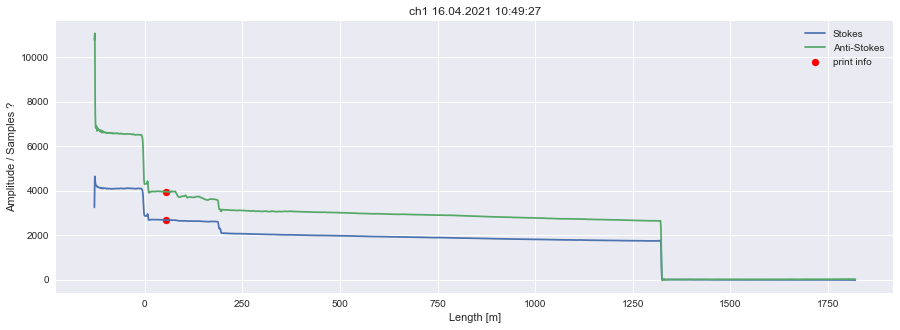

data point 184 at length 55 m
of ch1 at 16.04.2021 10:49:27

Stokes value: 2679.25
Anti_Stokes: value: 3947.0


In [3]:
# Plot data, check if the values are the same as in Charon, at a few points - visual for anti stokes and for stokes with cursor --> values are equal
fibre_location=55 #Input for printing values
channel="ch1"
date=stokes_16to22_042021[channel].columns[0]

plt.style.use("seaborn")
plt.figure(figsize=(15,5))
plt.plot(stokes_16to22_042021[channel][date],label="Stokes")
plt.plot(antistokes_16to22_042021[channel][date],label="Anti-Stokes")
plt.title(channel + " " + date)
plt.ylabel("Amplitude / Samples ?") #nicht sicher was das genau ist
plt.xlabel("Length [m]")

# mark datapoint where information is printed
plt.scatter(fibre_location,stokes_16to22_042021[channel][date][fibre_location],color="r",label="print info")
plt.scatter(fibre_location,antistokes_16to22_042021[channel][date][fibre_location],color="r")
plt.legend()
plt.show()


# print some values for comparing with Charon3
data_point=fibre_location+129 # charon3 also starts with datapoint, like python
print(f"data point {data_point} at length {fibre_location} m")
print(f"of {channel} at {date}")
print()
print(f"Stokes value: {stokes_16to22_042021[channel][date][fibre_location]}")
print(f"Anti_Stokes: value: {antistokes_16to22_042021[channel][date][fibre_location]}")

In [4]:
# Convert data to db

# Liste von Daten db and non-db value um zu checken ob umrechnung korreckt ist
# These were read from the displayed values in Charon3
# in charon3 plots abgelesen
data_point=[0,184,205,829,1464,1488,1496]
position=[-129,55,76,700,1335,1359,1367]
level_db=[17.55,17.14,17.13,16.4,0,0.1,1.03]
amplitude_samples=[3242.97,2679.25,2670.17,1901.13,0.43,1.05,1.61]
# compile read data in dataframe
df=pd.DataFrame([data_point,position,level_db,amplitude_samples])
df=df.T
df.columns=["data point","position","level_db","amplitude_samples"]
display(df)

# Checken ob Werte von Dataframes (exportierte Daten von Charon3) mit diesen Dataframe übereinstimmen
# Ja sie stimmen überein
#data_check_conversion=stokes_16to22_042021["ch1"]["16.04.2021 10:49:27"]
#print("position     value")
#for position in df["position"].values:
#    print(f"{position}      {data_check_conversion[position]}")

def conversion_to_db(value):
    """convert counts to db"""
    #alles das gleiche --> log Rechenregeln
    result=5*np.log10(value) 
    result=np.log10(value**5)
    result=10*np.log10(value**0.5) #Kommentar Norbert: evntl. am wahrscheinlichsten; Gleichung Rückstreuintensität
    result=20*np.log10(value**0.25)
    return result

def check_conversion_to_db_function(db,counts):
    """
    input:
    db: values in decibil / logarithmic
    counts: values in linear

    all neagtive values are displayed as zero in Charon3
    """
    print()
    print("check_conversion_to_db_function output:")
    print()
    for i in range(len(counts)):
        if conversion_to_db(counts[i]) - db[i] <= 0.01 and conversion_to_db(counts[i]) - db[i] >= -0.01:
            print(f"values are equal: {db[i]} {conversion_to_db(counts[i])}")
        elif db[i]==0:
            print()
            print(f"displayed value in charon is zero: {db[i]}")
            print(f"calculated value is {conversion_to_db(counts[i])}")
            print()
        else:
            print("values are not equal")
            print(f"conversion of {counts[i]} to {conversion_to_db(counts[i])}")
            print(f"real conversion value: {db[i]}")
            print()
    print("check_conversion_to_db_function output finished")

# check conversion function
db=df["level_db"].values
counts=df["amplitude_samples"].values
check_conversion_to_db_function(db,counts)

,data point,position,level_db,amplitude_samples
0,0.0,-129.0,17.55,3242.97
1,184.0,55.0,17.14,2679.25
2,205.0,76.0,17.13,2670.17
3,829.0,700.0,16.40,1901.13
4,1464.0,1335.0,0.00,0.43
5,1488.0,1359.0,0.10,1.05
6,1496.0,1367.0,1.03,1.61



check_conversion_to_db_function output:

values are equal: 17.55 17.55471465564559
values are equal: 17.14 17.140066196922778
values are equal: 17.13 17.132694560964502
values are equal: 16.4 16.39505907552207

displayed value in charon is zero: 0.0
calculated value is -1.8326577221020677

values are equal: 0.1 0.10594649534969107
values are equal: 1.03 1.0341293801592486
check_conversion_to_db_function output finished


C:\Users\Mathis\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


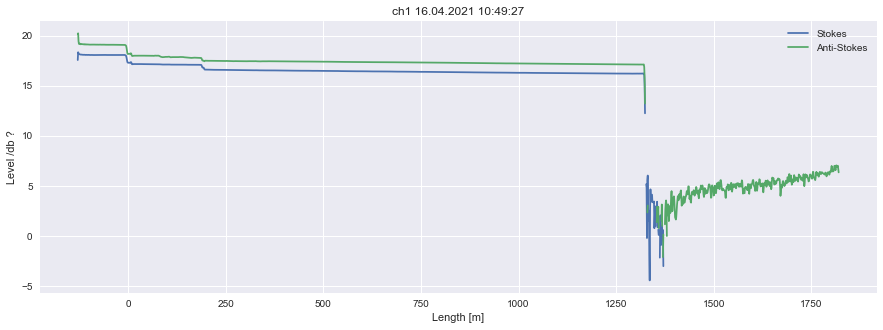

In [5]:
# plot converted db values
# looks like the plot in Charon3
channel="ch1"
date=stokes_16to22_042021[channel].columns[0]

stokes_db=conversion_to_db(stokes_16to22_042021[channel][date])
antistokes_db=conversion_to_db(antistokes_16to22_042021[channel][date])

plt.style.use("seaborn")
plt.figure(figsize=(15,5))
plt.plot(stokes_db,label="Stokes")
plt.plot(antistokes_db,label="Anti-Stokes")
plt.title(channel + " " + date)
plt.ylabel("Level /db ?") #nicht sicher was das genau ist
plt.xlabel("Length [m]")
plt.legend()
plt.show()

In [ ]:
# begin calculating it into temperautes



In [ ]:
# compare calculated temp with temp esported from charon